In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from keras.models import load_model

import util

Using TensorFlow backend.


In [2]:
train_df = pd.read_csv("nih/train-small.csv")
valid_df = pd.read_csv("nih/valid-small.csv")

test_df = pd.read_csv("nih/test.csv")

train_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00027079_001.png,0,0,0,0,0,0,0,0,0,0,0,27079,1,0,0
1,00004477_001.png,1,0,0,0,1,0,0,0,0,0,0,4477,0,0,0
2,00018530_002.png,0,0,0,0,0,0,0,0,0,0,0,18530,0,0,0
3,00026928_001.png,0,0,0,0,0,0,0,0,1,0,0,26928,0,0,0
4,00016687_000.png,0,0,0,0,0,0,0,0,0,0,1,16687,0,0,0


In [3]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li> Make use of python's set.intersection() function. </li>
</ul>
</p>

In [4]:
# Checking for Data Leakage
def check_for_leakage(df1, df2, patient_col):
    
    df1_patients_unique = set(df1[patient_col].values)
    df2_patients_unique = set(df2[patient_col].values)
    
    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)

    leakage = len(patients_in_both_groups) > 0
    
    return leakage

In [6]:
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'PatientId')))
print("leakage between valid and test: {}".format(check_for_leakage(valid_df, test_df, 'PatientId')))

leakage between train and test: False
leakage between valid and test: False


In [7]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
     
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [8]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="Image", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [9]:
IMAGE_DIR = "nih/images-small/"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

getting train generator...


/opt/conda/lib/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 866 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 866 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 9 validated image filenames.
getting train and valid generators...
Found 9 validated image filenames.


/opt/conda/lib/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 108 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 1 validated image filenames.
Found 420 validated image filenames.


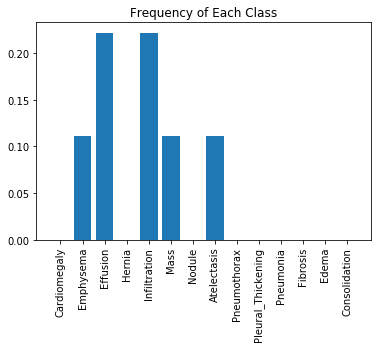

In [11]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

In [12]:
def compute_class_freqs(labels):
    
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels, axis=0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

In [14]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.        , 0.11111111, 0.22222222, 0.        , 0.22222222,
       0.11111111, 0.        , 0.11111111, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

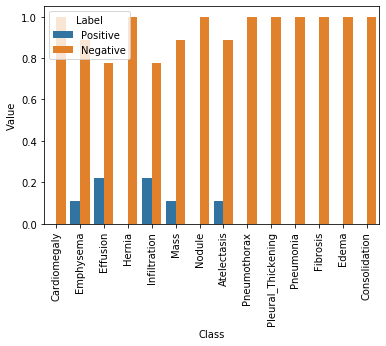

In [15]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

In [16]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

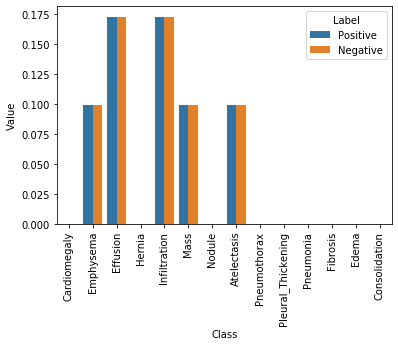

In [17]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [23]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
   
    def weighted_loss(y_true, y_pred):
    
        loss = 0.0

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class
            loss_pos = -1 * K.mean(pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon))
            loss_neg = -1 * K.mean(neg_weights[i] * (1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + epsilon))
            loss += loss_pos + loss_neg
        
        return loss
    
        ### END CODE HERE ###
    return weighted_loss

In [20]:
# create the base pre-trained model
base_model = DenseNet121(weights='./nih/densenet.hdf5', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




<a name='4'></a>
## 4 Training [optional]

**Note** that we have already provided a pre-trained model, so you don't need to run the following training cell (as it will take some time).

With our model ready for training, we will use the `model.fit()` function in Keras to train our model. 
- We are training on a small subset of the dataset (~1%).  


In [ ]:
# """
# OPTIONAL: uncomment this code to practice training the model.
# This is optional because we have loaded pre-trained weights after this.
# """

# history = model.fit_generator(train_generator, 
#                               validation_data=valid_generator,
#                               steps_per_epoch=100, 
#                               validation_steps=25, 
#                               epochs = 3)

# plt.plot(history.history['loss'])
# plt.ylabel("loss")
# plt.xlabel("epoch")
# plt.title("Training Loss Curve")
# plt.show()

In [ ]:
model.load_weights("./nih/pretrained_model.h5")

In [ ]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

In [ ]:
auc_rocs = util.get_roc_curve(labels, predicted_vals, test_generator)

For reference, here's the AUC figure from the ChexNeXt paper which includes AUC values for their model as well as radiologists on this dataset:

<img src="https://journals.plos.org/plosmedicine/article/figure/image?size=large&id=10.1371/journal.pmed.1002686.t001" width="80%">


In [ ]:
df = pd.read_csv("nih/train-small.csv")
IMAGE_DIR = "nih/images-small/"

#only show the lables with top 4 AUC
labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]

In [ ]:
util.compute_gradcam(model, '00008270_015.png', IMAGE_DIR, df, labels, labels_to_show)

In [ ]:
util.compute_gradcam(model, '00011355_002.png', IMAGE_DIR, df, labels, labels_to_show)

In [ ]:
util.compute_gradcam(model, '00029855_001.png', IMAGE_DIR, df, labels, labels_to_show)

In [ ]:
util.compute_gradcam(model, '00005410_000.png', IMAGE_DIR, df, labels, labels_to_show)